In [141]:
import os
import requests
import zipfile

# 下載模型
def download_glove_model(target_dir):
    
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # GloVe 4 模型下載連結
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    
    # 下載模型文件
    response = requests.get(url)
    
    # 將文件寫入到本地
    with open(os.path.join(target_dir, "glove.6B.zip"), "wb") as f:
        f.write(response.content)
    
    print("Download completed.")

# 解壓縮模型文件
def unzip_model(zip_file, target_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

    print("Extraction completed.")


target_dir = "./glove_model"
download_glove_model(target_dir)
unzip_model(os.path.join(target_dir, "glove.6B.zip"), target_dir)


Download completed.
Extraction completed.


In [218]:
from gensim.models import KeyedVectors

# GloVe 詞向量文件
glove_file = "./glove_model/glove.6B.300d.txt"

# 載入 GloVe 模型
model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
model.wv=model
print("Model vocabulary:", len(model.wv.index_to_key))

Model vocabulary: 400000


In [221]:
import os
from gensim.models import KeyedVectors
import pandas as pd

folder_paths = [
    "./BATS_3.0/1_Inflectional_morphology",
    "./BATS_3.0/2_Derivational_morphology",
    "./BATS_3.0/3_Encyclopedic_semantics",
    "./BATS_3.0/4_Lexicographic_semantics"
]
data_list=[]

for folder_path in folder_paths:
    total_questions = 0
    correct_answers = 0

    files = os.listdir(folder_path)
    for file in files:
        filename=file[:-4]
        if file.endswith(".txt"):
            # 開啟檔案
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r') as file:
                plural_dict = {}
                # 逐行讀取
                for line in file:
                    singular, plural = line.strip().split('\t')
                    plural_forms = plural.split('/')
                    # 加入字典
                    plural_dict[singular] = plural_forms

            for key, value in plural_dict.items():
                if len(value) > 0:
                    total_questions += len(value)
                    for word2 in value:
                        
                        # 檢查詞彙是否存在於模型中
                        if all(word in model.wv.index_to_key for word in [key, word2]):
                            # 類比預測
                            try:
                                predicted_words = [pred[0] for pred in model.wv.most_similar(positive=[key, word2], topn=len(value))]
                                
                                if any(pred_word in value for pred_word in predicted_words):
                                    correct_answers += 1
                            except KeyError:
                                pass  



        # 計算準確度
        if total_questions > 0:
            accuracy = correct_answers / total_questions
            # print("Total questions:", total_questions)
            # print("Correct answers:", correct_answers)
            # print(filename)
            # print("Accuracy:", accuracy)
            data_list.append({'File': filename, 'Accuracy': accuracy})
        else:
            print("No questions found.")
            
result = pd.DataFrame(data_list)
print(result)

                          File  Accuracy
0      I01 [noun - plural_reg]  0.000000
1    I02 [noun - plural_irreg]  0.000000
2      I03 [adj - comparative]  0.000000
3      I04 [adj - superlative]  0.000000
4        I05 [verb_inf - 3pSg]  0.000000
5        I06 [verb_inf - Ving]  0.000000
6         I07 [verb_inf - Ved]  0.000000
7       I08 [verb_Ving - 3pSg]  0.000000
8        I09 [verb_Ving - Ved]  0.000000
9        I10 [verb_3pSg - Ved]  0.000000
10         D01 [noun+less_reg]  0.037736
11            D02 [un+adj_reg]  0.038462
12            D03 [adj+ly_reg]  0.025974
13          D04 [over+adj_reg]  0.039370
14          D05 [adj+ness_reg]  0.032895
15           D06 [re+verb_reg]  0.030986
16         D07 [verb+able_reg]  0.029412
17         D08 [verb+er_irreg]  0.026201
18       D09 [verb+tion_irreg]  0.051429
19       D10 [verb+ment_irreg]  0.048527
20     E01 [country - capital]  0.057692
21    E02 [country - language]  0.116279
22      E03 [UK_city - county]  0.083799
23    E04 [name 

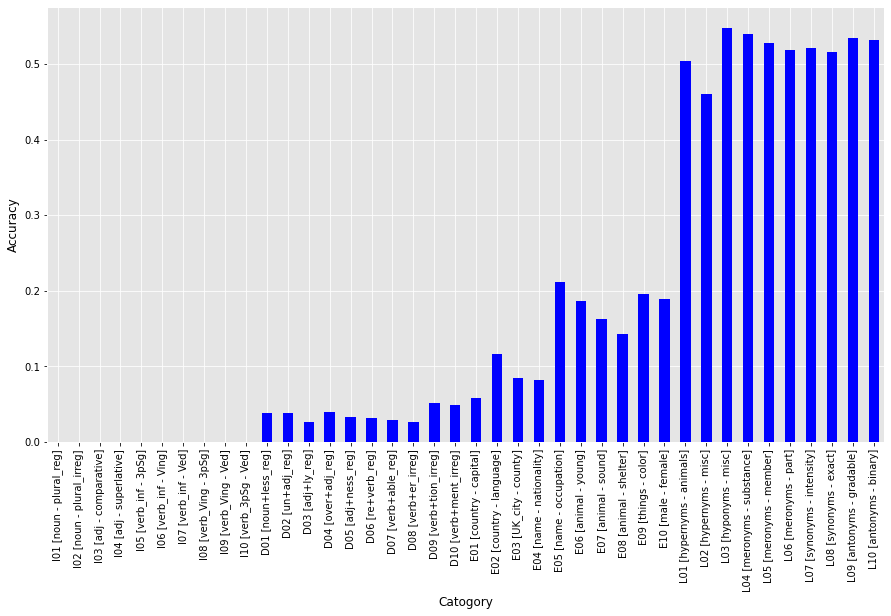

In [222]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

plt.style.use('ggplot')

result.plot(kind='bar', x='File', y='Accuracy', color='blue', legend=None,ax=ax)

ax.set_xlabel('Catogory',color='black')
ax.set_ylabel('Accuracy',color='black')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

plt.show()
